# Sinkhorn

Consider a simple example with given $i.i.d.$ samples from two Gaussian distributions $X_1,...,X_n,Y_1,...,Y_m$. We fix the cost as the squared Euclidean distance $c(x,y) = |x-y|^2$ to match the 2-Wasserstein distance.

Measures $\mu = \frac{1}{n}\sum_{i=1}^n \delta_{X_i},\nu = \frac{1}{m}\sum_{j=1}^m \delta_{Y_j}$ are formulated as empirical measures for the sake of simplicity. In addition, we require $m=n$ so that the optimal transport map is guaranteed to exist. When $m,n$ are large enough, the empirical measure is expected to be close to the original Gaussians.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class OT:
    def __init__(self,mu_1,sigma_1,mu_2,sigma_2,n,m,EPS):
        # Source and target dists
        self.src_dist = stats.norm(mu_1,sigma_1)
        self.tgt_dist = stats.norm(mu_2,sigma_2)
        
        # Generate samples
        self.n = n
        self.m = m
        self.src_sample = self.src_dist.rvs(size = n)
        self.tgt_sample = self.tgt_dist.rvs(size = m)
        
        # Regularization intensity
        self.EPS = EPS
        
        # Probability mass vectors
        self.mu = (1/n) * np.ones((n,1))
        self.nu = (1/m) * np.ones((m,1))
        
    # Quadratic cost
    def c(self,x,y):
        return np.sum((x - y) ** 2)
    
    # Gibbs kernel
    def set_Gibbs_kernel(self):
        K = np.empty((self.n,self.m))
        for i in range(self.n):
            for j in range(self.m):
                K[i,j] = np.exp(- (1/self.EPS) * self.c(self.src_sample[i],self.tgt_sample[j]))
        self.K = K
        return
        
    # Sinkhorn algorithm
    def Sinkhorn(self,eta,xi,TOL = 1e-4):
        assert np.all(eta > 0) and np.all(xi > 0), "eta and xi has to be positive!"
        last_eta = np.zeros((self.n,1))
        last_xi = np.zeros((self.m,1))
        while np.sum((last_eta - eta) ** 2) > TOL or np.sum((last_eta - eta) ** 2) > TOL:
            last_eta = eta
            last_xi = xi
        
            # Sinkhorn iteration
            eta = self.mu / (self.K @ xi)
            xi = self.nu / (self.K.transpose() @ eta)
            
        self.eta_star = eta
        self.xi_star = xi
        return
    
    # Get the optimal coupling (Kantorovich)
    def set_pi_star(self):
        # Reshape into 1d array
        eta_star = np.reshape(self.eta_star,(-1,))
        xi_star = np.reshape(self.xi_star,(-1,))
        self.pi_star = np.diag(eta_star) @ self.K @ np.diag(xi_star)
        return
    
    # Get the optimal transport map
    def set_T_star(self):
        T_star = dict()
        for i, _ in enumerate(self.src_sample):
            # Find the index j of the maximum value in the i-th row of pi_star
            # T shall map x_i to y_j
            j = np.argmax(self.pi_star[i, :])
            T_star[i] = j
        self.T_star = T_star

In Sinkhorn algorithm, first calculate the Gibbs kernel $K$ that
$$K_{ij} := e^{-\frac{1}{\varepsilon}c(x_i,y_j)},$$
where $\varepsilon >0$ is the intensity of regularization effects.

Afterwards, the update is given by:
$$\eta^{n+1} = \frac{\mu}{K\xi^n},\xi^{n+1} = \frac{\nu}{K^T\eta^{n+1}},$$
where the optimal coupling in the Kantorovich problem is given by
$$\pi^*(x,y) = \text{diag}(\eta^*)K\text{diag}(\xi^*).$$

In [3]:
mu_1 = 0
sigma_1 = 1
mu_2 = 10
sigma_2 = 2
EPS = 0.5
m = n = 1000

# Object
OT_prob = OT(mu_1,sigma_1,mu_2,sigma_2,n,m,EPS)

# Gibbs kernel
OT_prob.set_Gibbs_kernel()

# Solve OT
eta_init = np.ones((n,1))
xi_init = np.ones((m,1))
OT_prob.Sinkhorn(eta_init,xi_init)

# Get optimal coupling
OT_prob.set_pi_star()

Plot the optimal coupling as the solution to the entropy-regularized Kantorovich problem.

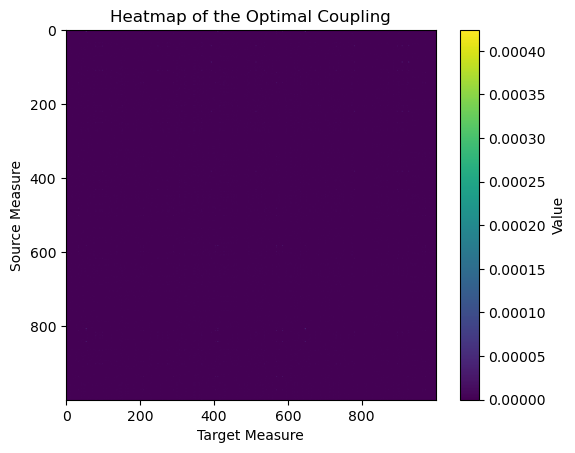

In [4]:
plt.imshow(OT_prob.pi_star)
plt.colorbar(label='Value')
plt.title('Heatmap of the Optimal Coupling')
plt.xlabel('Target Measure')
plt.ylabel('Source Measure')
plt.show()

In the case where source and target measures are both empirical measures with the same number of masses, we can extract the optimal transport map from the optimal coupling $\pi^* = (id,T^*)_\#\mu$.

In [5]:
OT_prob.set_T_star()

## Geodesic in Wasserstein sense

At this point, we can interpolate the optimal transport map to get the geodesic $\mu_t = ((1-t)\text{id} + tT)_\#\mu$ in the Wasserstein space. This shows us how the optimal transport map is working.

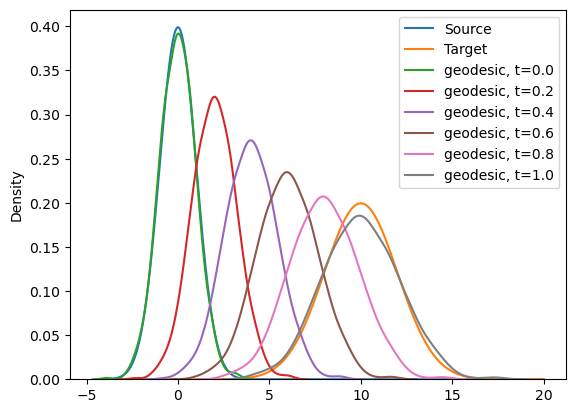

In [6]:
# Plot two densities
x = np.linspace(-4,20,1000)
plt.plot(x,OT_prob.src_dist.pdf(x),label = 'Source')
plt.plot(x,OT_prob.tgt_dist.pdf(x),label = 'Target')

t_list = np.linspace(0,1,6)
# The samples from mu pushed by T
T_push_mu = np.array([OT_prob.tgt_sample[OT_prob.T_star[i]] for i in range(n)])
for t in t_list:
    # Geodesic
    sample = (1 - t) * OT_prob.src_sample + t * T_push_mu
    sns.kdeplot(sample,label = "geodesic, t=" + str(np.round(t,2)))
plt.legend()
plt.show()